# Thesis Analysis: The Impact of Happiness Alignment on Funding Intention

**Researcher:** An V.B. Nguyen
**Date:** June 30, 2025

### **Objective:**
This notebook executes the complete data analysis pipeline for the thesis. It is structured into four phases:
1.  **Data Loading & Preparation:** Loads the two clean source files (`happiness_data_with_harmonized_ids.csv` and `investor_survey_filtered.csv`), performs final data type cleaning, and creates composite control variables.
2.  **Predictor Calculation:** Calculates the key predictor variables required for all three hypotheses (Alignment Duration, Consensus, and Temporal Duration) from the time-series data.
3.  **Modeling Dataset Creation & Standardization:** Constructs the final, dyad-level dataset for statistical analysis and standardizes all continuous variables for comparability.
4.  **Hypothesis Testing & Reporting:** Runs the three separate regression models and generates all APA-7 style tables and figures for the thesis results chapter.

In [16]:
# ==============================================================================
# PHASE 1 & 2: DATA PREPARATION AND PREDICTOR CALCULATION
# ==============================================================================

import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import os

print("--- PHASE 1: Loading and Preparing Source Data ---")

# --- Step 1.1: Load Source Files ---
try:
    # Load the harmonized time-series data and the filtered survey data
    happiness_df = pd.read_csv('happiness_data_with_harmonized_ids.csv', low_memory=False)
    survey_df = pd.read_csv('investor_survey_filtered.csv')
    print("✅ Successfully loaded both source datasets.")
except FileNotFoundError as e:
    print(f"❌ ERROR: A required source file was not found. Please check your filenames. Details: {e}")
    raise

# --- Step 1.2: Prepare Survey Data ---
survey_df.columns = survey_df.columns.str.strip()
cols_to_convert = ['probinv', 'quality', 'confbusiness', 'prep1', 'prep2', 'prep3', 'prep4', 'prep5']
for col in cols_to_convert:
    if col in survey_df.columns:
        survey_df[col] = pd.to_numeric(survey_df[col], errors='coerce')
survey_df['Perceived_Preparedness'] = survey_df[['prep1', 'prep2', 'prep3', 'prep4', 'prep5']].mean(axis=1)
print("✅ Survey data cleaned and composite variables created.")
print("-" * 50)

print("--- PHASE 2: Calculating Predictor Variables ---")

# --- Step 2.1: Harmonize and Merge Datasets ---
# We use the 'startup' column in the survey data as the clean key
survey_df.rename(columns={'startup': 'session_id'}, inplace=True)
master_df = pd.merge(happiness_df, survey_df, on='session_id', how='inner')
print(f"✅ Merge successful. Master time-series created with {len(master_df)} rows.")

# --- Step 2.2: Calculate Peak Happiness, Temporal Placement, and Alignment ---
peak_events = master_df.loc[master_df.groupby('pitchid')['pitcher_happy'].idxmax()]
peak_events = peak_events[['pitchid', 'timestamp']].rename(columns={'timestamp': 'peak_happiness_timestamp'})
analysis_df = pd.merge(master_df, peak_events, on='pitchid', how='left')
analysis_df['timestamp'] = pd.to_numeric(analysis_df['timestamp'], errors='coerce')
analysis_df.dropna(subset=['timestamp', 'peak_happiness_timestamp'], inplace=True)
pitch_durations = analysis_df.groupby('pitchid')['timestamp'].max().reset_index(name='max_timestamp')
analysis_df = pd.merge(analysis_df, pitch_durations, on='pitchid', how='left')
analysis_df['temporal_placement'] = 'Middle'
analysis_df.loc[analysis_df['timestamp'] <= analysis_df['max_timestamp'] * 0.20, 'temporal_placement'] = 'Beginning'
analysis_df.loc[analysis_df['timestamp'] >= analysis_df['max_timestamp'] * 0.80, 'temporal_placement'] = 'End'
print("✅ Calculated temporal placement segments for H3.")

time_window = 2.0; happiness_threshold = 0.5; frame_duration = 0.5
analysis_df['investor_position_suffix'] = analysis_df['investorid'].astype(str).str[-1]
durations_list = []
for suffix, judge_pos in [('1', 'L'), ('2', 'M'), ('3', 'R')]:
    judge_df = analysis_df[analysis_df['investor_position_suffix'] == suffix].copy()
    judge_col = f'judge_{judge_pos}_happy'
    if judge_col in judge_df.columns:
        judge_df['is_aligned'] = ((judge_df['timestamp'] >= judge_df['peak_happiness_timestamp'] - time_window) & (judge_df['timestamp'] <= judge_df['peak_happiness_timestamp'] + time_window) & (judge_df[judge_col] > happiness_threshold)).astype(int)
        duration = judge_df.groupby(['investorid', 'temporal_placement'])['is_aligned'].sum() * frame_duration
        durations_list.append(duration)

duration_long_df = pd.concat(durations_list).reset_index()
duration_wide_df = duration_long_df.pivot_table(index='investorid', columns='temporal_placement', values='is_aligned', fill_value=0).reset_index()
duration_wide_df.rename(columns={'Beginning': 'Duration_Beginning', 'Middle': 'Duration_Middle', 'End': 'Duration_End'}, inplace=True)
print("✅ Calculated alignment duration for each temporal segment.")
print("-" * 50)

--- PHASE 1: Loading and Preparing Source Data ---
✅ Successfully loaded both source datasets.
✅ Survey data cleaned and composite variables created.
--------------------------------------------------
--- PHASE 2: Calculating Predictor Variables ---
✅ Merge successful. Master time-series created with 2353509 rows.
✅ Calculated temporal placement segments for H3.
✅ Calculated alignment duration for each temporal segment.
--------------------------------------------------


### PHASE 3: CREATE FINAL MODELING DATASET

This cell takes the raw survey data as a base and merges the calculated predictor variables (`Duration` and `Consensus`) into it. This creates the final, dyad-level dataset required for the multilevel regression models.

In [17]:
# --- Start with the survey data as our base ---
model_df = survey_df.copy()

# --- Merge the calculated durations into the survey data ---
model_df = pd.merge(model_df, duration_wide_df, on='investorid', how='left')
model_df['Duration_of_Aligned_Peak_Happiness'] = model_df.get('Duration_Beginning', 0) + model_df.get('Duration_Middle', 0) + model_df.get('Duration_End', 0)

# --- Calculate Consensus and Final Cleanup ---
consensus_df = model_df[model_df['Duration_of_Aligned_Peak_Happiness'] > 0].groupby('pitchid')['investorid'].nunique().reset_index(name='Consensus_of_Alignment')
model_df = pd.merge(model_df, consensus_df, on='pitchid', how='left')
model_df.fillna(0, inplace=True)

# --- Save the final dataset ---
model_df.to_csv('FINAL_ANALYSIS_DATASET_UNSTANDARDIZED.csv', index=False)
print("✅ Final modeling dataset created and saved as 'FINAL_ANALYSIS_DATASET_UNSTANDARDIZED.csv'.")
print("Preview of the final data before standardization:")
display(model_df.head())

✅ Final modeling dataset created and saved as 'FINAL_ANALYSIS_DATASET_UNSTANDARDIZED.csv'.
Preview of the final data before standardization:


,wave,pitchid,session_id,studententrepreneur,investorid,investor,coach1,coach2,coach3,coach4,...,risk4,confbusiness,related,ranking,Perceived_Preparedness,Duration_Beginning,Duration_End,Duration_Middle,Duration_of_Aligned_Peak_Happiness,Consensus_of_Alignment
0,1.0,p11,Little Sister,Hero de Smeth,i11,Remco Verhoef,4.0,4,4,4.0,...,4.0,5.0,0.0,2,2.4,0.0,0.0,0.0,0.0,1
1,1.0,p11,Little Sister,Hero de Smeth,i12,Tim Stribos,3.0,4,3,4.0,...,3.0,5.0,3.0,4,2.8,0.0,4.5,0.0,4.5,1
2,1.0,p11,Little Sister,Hero de Smeth,i13,Sjoerd Coolen,4.0,4,4,4.0,...,1.0,6.0,9.0,1,3.4,0.0,0.0,0.0,0.0,1
3,1.0,p12,FLIPR,Neil Timmermans,i11,Remco Verhoef,3.0,3,3,3.0,...,3.0,5.0,0.0,4,3.4,0.0,0.0,0.0,0.0,1
4,1.0,p12,FLIPR,Neil Timmermans,i12,Tim Stribos,3.0,3,3,3.0,...,4.0,7.0,10.0,1,3.4,0.0,4.5,0.0,4.5,1


### PHASE 4: STANDARDIZATION, HYPOTHESIS TESTING, AND REPORTING

This final cell performs the statistical analysis. First, it standardizes all continuous predictor variables (Z-scoring) to make their coefficients comparable. Then, it runs the three separate multilevel models to test H1, H2, and H3. Finally, it generates all the APA-7 style tables and figures needed for the thesis document.

✅ Predictor variables standardized.
Running models on 165 complete observations.


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.420896
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: Mixed

✅ All statistical models have been successfully fitted.

--- Table for Thesis: Descriptive Statistics of Key Variables ---


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.822581
  warnings.warn(msg, ConvergenceWarning)


,N,mean,std,min,max
Funding Intention (0-100),165,30.27,23.43,0.0,90.0
Alignment Duration (s),165,16.69,28.06,0.0,96.5
Alignment Consensus (0-3),165,2.40,0.71,1.0,3.0
Perceived Preparedness (1-5),165,3.27,0.72,1.2,5.0
Venture Quality (0-100),165,38.15,23.63,0.0,90.0
Investor Confidence (1-7),165,5.59,1.05,0.0,8.0



--- Table 1: Multilevel Model for H1 (Alignment Duration) ---


,β,SE,z,p,CI 95% Lower,CI 95% Upper
Intercept,30.273***,0.977,30.982,< .001,28.358,32.188
Duration_of_Aligned_Peak_Happiness_z,1.489,0.998,1.491,0.136,-0.468,3.445
Perceived_Preparedness_z,1.909,1.225,1.559,0.119,-0.492,4.310
quality_z,19.051***,1.276,14.927,< .001,16.550,21.552
confbusiness_z,1.098,1.001,1.097,0.272,-0.863,3.060
Group Var,0.001,0.123,0.010,0.992,-0.240,0.242



--- Table 2: Multilevel Model for H2 (Alignment Consensus) ---


,β,SE,z,p,CI 95% Lower,CI 95% Upper
Intercept,30.273***,0.983,30.783,< .001,28.345,32.200
Consensus_of_Alignment_z,-0.321,1.047,-0.306,0.76,-2.373,1.732
Perceived_Preparedness_z,1.833,1.264,1.450,0.147,-0.644,4.310
quality_z,18.784***,1.331,14.116,< .001,16.176,21.392
confbusiness_z,1.017,1.010,1.006,0.314,-0.963,2.996
Group Var,0.001,0.116,0.009,0.993,-0.226,0.228



--- Table 3: Multilevel Model for H3 (Temporal Placement) ---


,β,SE,z,p,CI 95% Lower,CI 95% Upper
Intercept,30.273***,0.982,30.841,< .001,28.349,32.197
Duration_Beginning_z,1.307,1.013,1.290,0.197,-0.679,3.292
Duration_End_z,0.671,1.005,0.668,0.504,-1.298,2.639
Perceived_Preparedness_z,1.872,1.233,1.518,0.129,-0.545,4.289
quality_z,19.04***,1.296,14.694,< .001,16.500,21.580
confbusiness_z,1.129,1.015,1.112,0.266,-0.860,3.119
Group Var,0.002,0.125,0.017,0.987,-0.244,0.248


/var/folders/b5/xvtvvnr52fx0vw0n1qrkgv9r0000gn/T/ipykernel_21175/1961960366.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=model_df, x='Consensus_of_Alignment', y='probinv', palette='viridis')



✅ Figures for H1 and H2 have been generated and saved as 'thesis_figures_H1_H2.png'


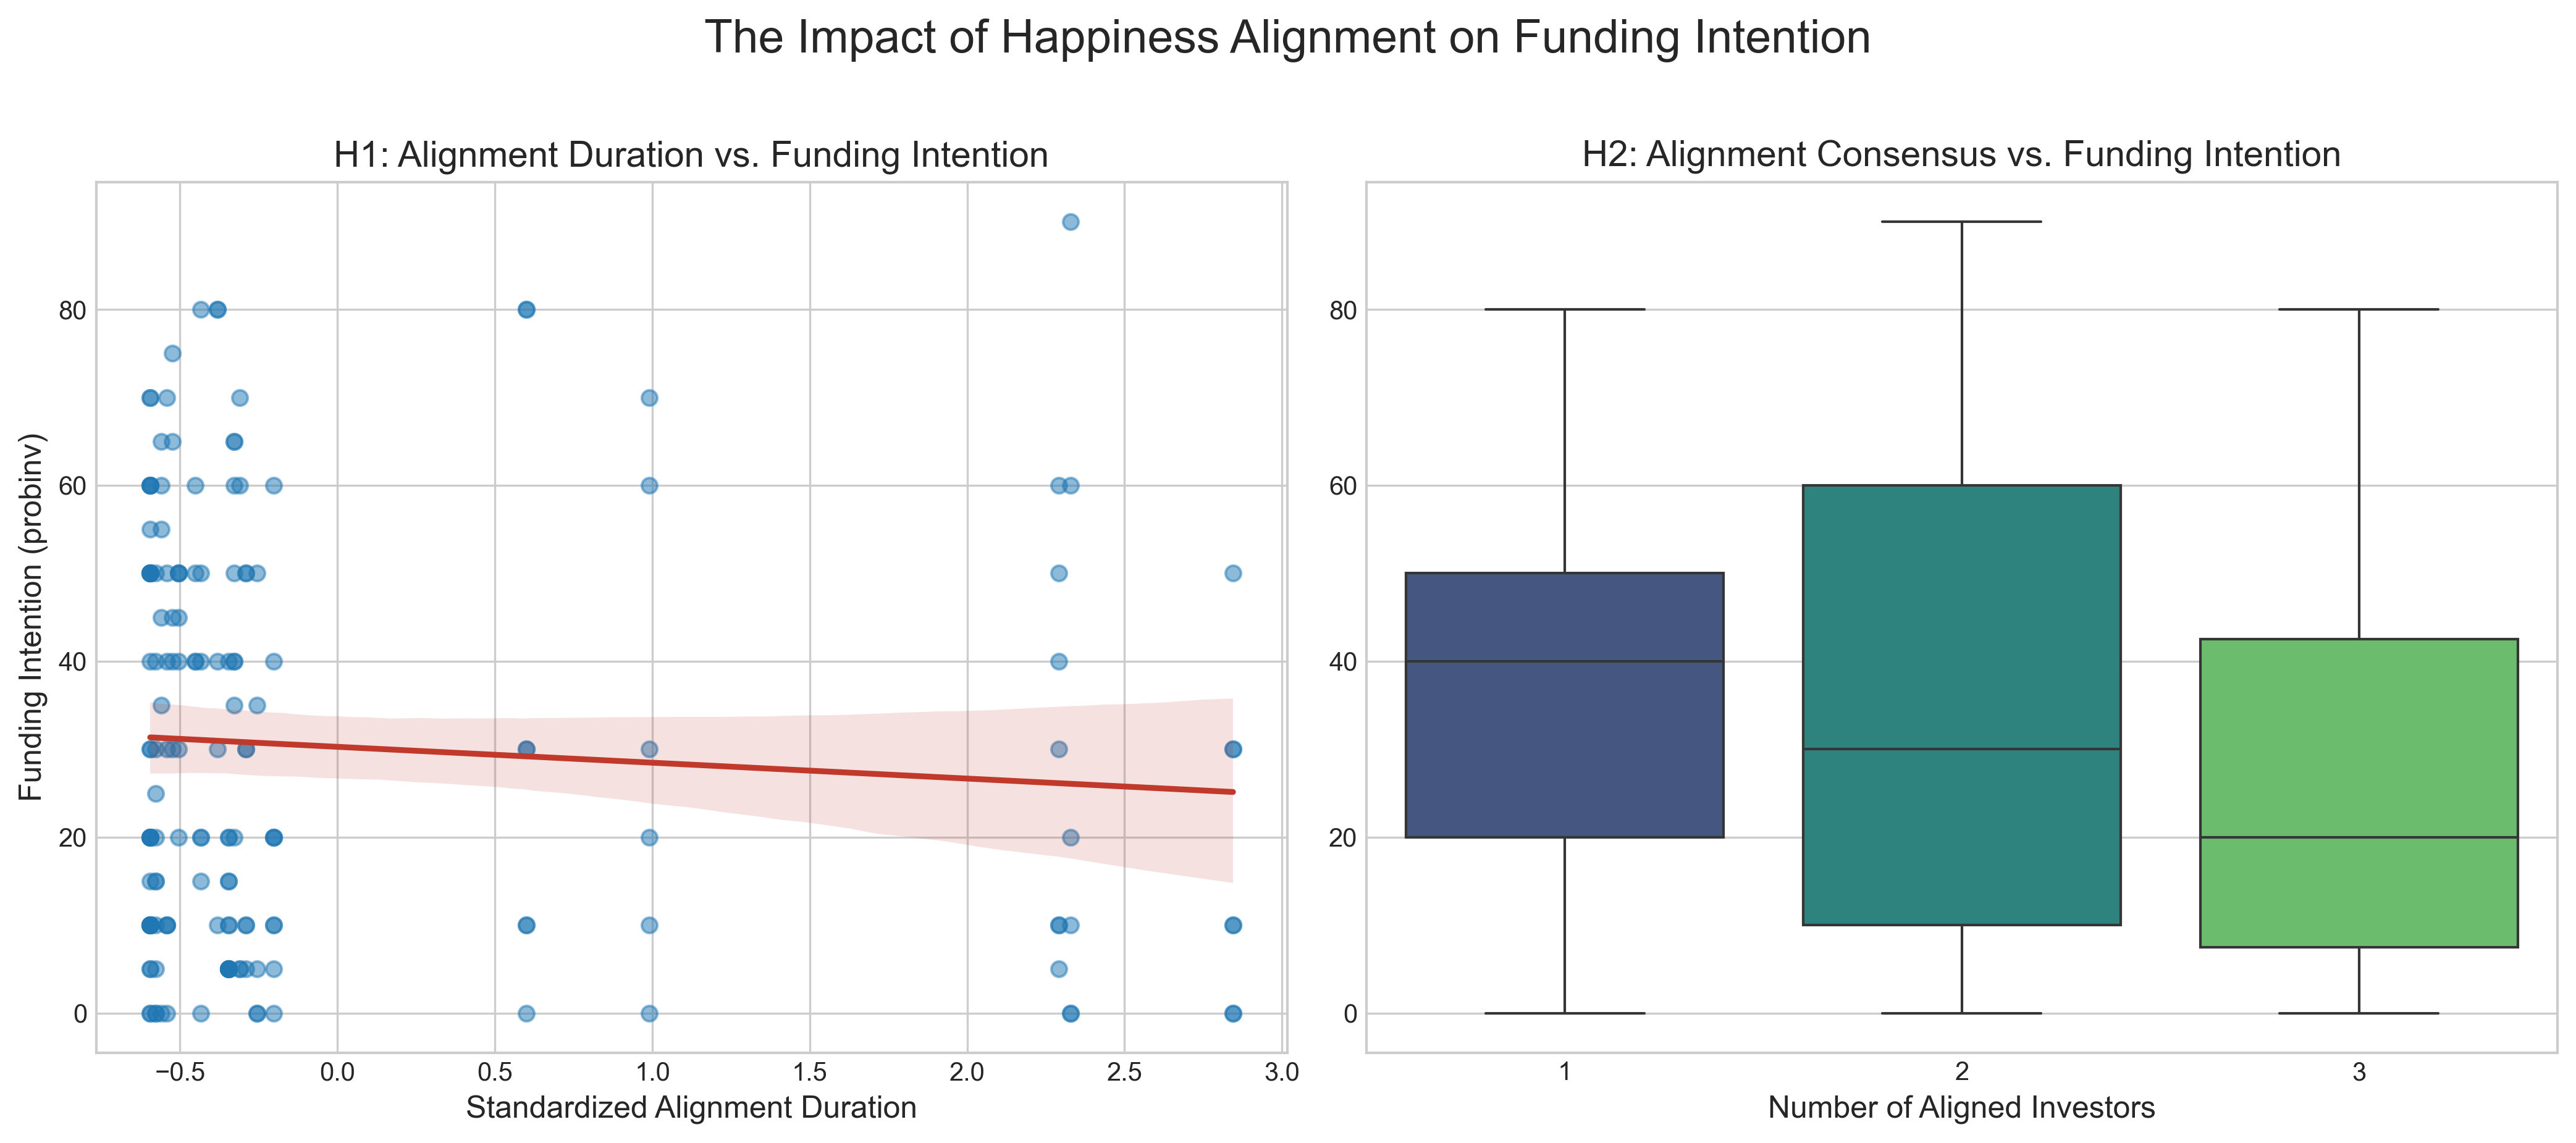


🎉 THESIS ANALYSIS AND REPORTING COMPLETE! 🎉


In [18]:
# --- Standardize (Z-score) continuous variables ---
vars_to_standardize = ['Duration_of_Aligned_Peak_Happiness', 'Consensus_of_Alignment', 'Duration_Beginning', 'Duration_End', 'Perceived_Preparedness', 'quality', 'confbusiness']
for var in vars_to_standardize:
    mean = model_df[var].mean(); std = model_df[var].std()
    if std > 0: model_df[f'{var}_z'] = (model_df[var] - mean) / std
    else: model_df[f'{var}_z'] = 0
print("✅ Predictor variables standardized.")

# --- Prepare final data for modeling ---
model_vars = ['probinv', 'Duration_of_Aligned_Peak_Happiness_z', 'Consensus_of_Alignment_z', 'Duration_Beginning_z', 'Duration_End_z',
              'Perceived_Preparedness_z', 'quality_z', 'confbusiness_z', 'pitchid']
final_model_data = model_df[model_vars].dropna()
final_model_data['pitchid'] = final_model_data['pitchid'].astype(str)
print(f"Running models on {len(final_model_data)} complete observations.")

if len(final_model_data) > 10:
    # --- Run all three models ---
    model1 = smf.mixedlm("probinv ~ Duration_of_Aligned_Peak_Happiness_z + Perceived_Preparedness_z + quality_z + confbusiness_z", data=final_model_data, groups=final_model_data["pitchid"]).fit(method=["bfgs"])
    model2 = smf.mixedlm("probinv ~ Consensus_of_Alignment_z + Perceived_Preparedness_z + quality_z + confbusiness_z", data=final_model_data, groups=final_model_data["pitchid"]).fit(method=["bfgs"])
    model3 = smf.mixedlm("probinv ~ Duration_Beginning_z + Duration_End_z + Perceived_Preparedness_z + quality_z + confbusiness_z", data=final_model_data, groups=final_model_data["pitchid"]).fit(method=["bfgs"])
    print("✅ All statistical models have been successfully fitted.")
else:
    print("❌ ERROR: Not enough data remained after cleaning to run the models.")

# --- Generate APA-7 Style Descriptive Statistics Table ---
print("\n--- Table for Thesis: Descriptive Statistics of Key Variables ---")
desc_stats_df = model_df[['probinv', 'Duration_of_Aligned_Peak_Happiness', 'Consensus_of_Alignment', 'Perceived_Preparedness', 'quality', 'confbusiness']].copy()
desc_stats_df.rename(columns={
    'probinv': 'Funding Intention (0-100)', 'Duration_of_Aligned_Peak_Happiness': 'Alignment Duration (s)',
    'Consensus_of_Alignment': 'Alignment Consensus (0-3)', 'Perceived_Preparedness': 'Perceived Preparedness (1-5)',
    'quality': 'Venture Quality (0-100)', 'confbusiness': 'Investor Confidence (1-7)'
}, inplace=True)
descriptives = desc_stats_df.describe().round(2)
apa_table = descriptives.loc[['mean', 'std', 'min', 'max']].T
apa_table.insert(0, 'N', descriptives.loc['count'].astype(int))
display(apa_table)

# --- Generate APA-7 Style Tables ---
def format_apa_table(model_result, table_title):
    results_df = pd.DataFrame({
        'β': model_result.params, 'SE': model_result.bse, 'z': model_result.tvalues,
        'p': model_result.pvalues, 'CI 95% Lower': model_result.conf_int().iloc[:, 0],
        'CI 95% Upper': model_result.conf_int().iloc[:, 1]
    })
    results_df[['β', 'SE', 'z', 'CI 95% Lower', 'CI 95% Upper']] = results_df[['β', 'SE', 'z', 'CI 95% Lower', 'CI 95% Upper']].astype(float).round(3)
    p_values = pd.to_numeric(results_df['p'])
    stars = ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '' for p in p_values]
    results_df['β'] = results_df['β'].astype(str) + stars
    results_df['p'] = p_values.round(3).astype(str)
    results_df.loc[p_values < 0.001, 'p'] = '< .001'
    print(f"\n--- {table_title} ---")
    display(results_df)

format_apa_table(model1, "Table 1: Multilevel Model for H1 (Alignment Duration)")
format_apa_table(model2, "Table 2: Multilevel Model for H2 (Alignment Consensus)")
format_apa_table(model3, "Table 3: Multilevel Model for H3 (Temporal Placement)")

# --- Generate Figures ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
fig.suptitle('The Impact of Happiness Alignment on Funding Intention', fontsize=18, y=1.02)
sns.regplot(ax=axes[0], data=final_model_data, x='Duration_of_Aligned_Peak_Happiness_z', y='probinv', line_kws={"color": "#c0392b"}, scatter_kws={"alpha": 0.5})
axes[0].set_title('H1: Alignment Duration vs. Funding Intention', fontsize=14)
axes[0].set_xlabel('Standardized Alignment Duration', fontsize=12)
axes[0].set_ylabel('Funding Intention (probinv)', fontsize=12)
sns.boxplot(ax=axes[1], data=model_df, x='Consensus_of_Alignment', y='probinv', palette='viridis')
axes[1].set_title('H2: Alignment Consensus vs. Funding Intention', fontsize=14)
axes[1].set_xlabel('Number of Aligned Investors', fontsize=12)
axes[1].set_ylabel('')
plt.tight_layout()
plt.savefig('thesis_figures_H1_H2.png')
print("\n✅ Figures for H1 and H2 have been generated and saved as 'thesis_figures_H1_H2.png'")
plt.show()

# --- Save the final analysis-ready dataset ---
final_model_data.to_csv('FINAL_ANALYSIS_DATASET.csv', index=False)
print("\n🎉 THESIS ANALYSIS AND REPORTING COMPLETE! 🎉")